# Group Splitter Validation

Validate saved group-splitter predictions using parquet outputs and truth labels from the main data files.

This notebook does **not** run model inference.


In [1]:
import torch
import numpy as np
import polars as pl
from pathlib import Path
from datetime import datetime

from pioneerml.common.zenml import utils as zenml_utils
from pioneerml.common.evaluation.plots import (
    plot_multilabel_confusion_matrix,
    plot_roc_curves,
    plot_precision_recall_curves,
    plot_probability_distributions,
    plot_confidence_analysis,
)

PROJECT_ROOT = zenml_utils.find_project_root()
zenml_utils.setup_zenml_for_notebook(root_path=PROJECT_ROOT, use_in_memory=True)

print(f"Project root: {PROJECT_ROOT}")


Using ZenML repository root: /workspace
Ensure this is the top-level of your repo (.zen must live here).
Project root: /workspace


## List Available Prediction Files

Find saved `group_splitter` prediction parquet files.


In [2]:
# List available saved group-splitter prediction files
prediction_dir = Path(PROJECT_ROOT) / "data" / "group_splitter"
prediction_files = sorted(prediction_dir.glob("*_preds.parquet"))
if not prediction_files:
    raise ValueError(f"No prediction parquet files found in {prediction_dir}")

print(f"Found {len(prediction_files)} prediction file(s).")
for i, p in enumerate(prediction_files[:10]):
    print(f"[{i}] {p.name}")


Found 5 prediction file(s).
[0] ml_output_000_preds.parquet
[1] ml_output_001_preds.parquet
[2] ml_output_002_preds.parquet
[3] ml_output_003_preds.parquet
[4] ml_output_004_preds.parquet


## Prediction Source

Validation uses previously exported prediction parquet files from `data/group_splitter`.


In [3]:
# Validation now loads predictions from parquet files (no model inference run in this notebook)
print("Validation mode: load existing predictions + truth from parquet files.")


Validation mode: load existing predictions + truth from parquet files.


## Load Validation Data

Load the same data pattern used during training (or a subset for faster validation).


In [4]:
# Load validation parquet inputs and aligned group-splitter predictions

def _pick_pred(pred_dir: Path, main_path: Path) -> Path | None:
    candidates = [
        pred_dir / f"{main_path.stem}_preds.parquet",
        pred_dir / f"{main_path.stem}_preds_latest.parquet",
    ]
    for c in candidates:
        if c.exists():
            return c
    return None

main_dir = Path(PROJECT_ROOT) / "data"
main_paths = sorted(main_dir.glob("ml_output_*.parquet"))

# Example: uncomment to use a smaller subset
main_paths = main_paths[:1]

prediction_dir = Path(PROJECT_ROOT) / "data" / "group_splitter"
paired = []
for mp in main_paths:
    pp = _pick_pred(prediction_dir, mp)
    if pp is not None:
        paired.append((str(mp.resolve()), str(pp.resolve())))

if not paired:
    raise RuntimeError(
        "No aligned main/group-splitter prediction pairs found. "
        "Run group-splitter inference first."
    )

parquet_paths = [p[0] for p in paired]
group_splitter_pred_paths = [p[1] for p in paired]

print(f"Validation files: {len(parquet_paths)}")
for p in parquet_paths:
    print(" -", p)
print(f"Prediction files: {len(group_splitter_pred_paths)}")


Validation files: 1
 - /workspace/data/ml_output_000.parquet
Prediction files: 1


## Load Predictions And Truth

Load saved prediction parquet files and reconstruct aligned truth targets from input parquet files.


In [5]:
# Load predictions from saved parquet outputs and build truth labels from main parquet files

pred_blocks = []
target_blocks = []

for main_path, pred_path in zip(parquet_paths, group_splitter_pred_paths, strict=True):
    main_flat = (
        pl.scan_parquet(main_path)
        .select(["hits_time_group", "hits_particle_mask"])
        .with_columns(
            pl.int_range(pl.len(), dtype=pl.UInt32).alias("row_idx"),
            pl.int_ranges(
                pl.lit(0),
                pl.col("hits_time_group").list.len(),
                dtype=pl.UInt32,
            ).alias("truth_hit_idx"),
        )
        .explode(["truth_hit_idx", "hits_time_group", "hits_particle_mask"])
        .filter(pl.col("truth_hit_idx").is_not_null())
        .select(
            "row_idx",
            pl.col("truth_hit_idx"),
            pl.col("hits_time_group").cast(pl.Int64).alias("truth_time_group"),
            pl.col("hits_particle_mask").cast(pl.Int32).alias("truth_particle_mask"),
        )
        .sort(["row_idx", "truth_time_group", "truth_hit_idx"])
        .with_columns((pl.cum_count("truth_time_group").over("row_idx").cast(pl.Int64) - 1).alias("ord"))
        .collect()
    )

    pred_flat = (
        pl.scan_parquet(pred_path)
        .select(["time_group_ids", "pred_hit_pion", "pred_hit_muon", "pred_hit_mip"])
        .with_columns(
            pl.int_range(pl.len(), dtype=pl.UInt32).alias("row_idx"),
            pl.int_ranges(
                pl.lit(0),
                pl.col("time_group_ids").list.len(),
                dtype=pl.UInt32,
            ).alias("pred_hit_idx"),
        )
        .explode(["pred_hit_idx", "time_group_ids", "pred_hit_pion", "pred_hit_muon", "pred_hit_mip"])
        .filter(pl.col("pred_hit_idx").is_not_null())
        .select(
            "row_idx",
            pl.col("pred_hit_idx"),
            pl.col("time_group_ids").cast(pl.Int64).alias("pred_time_group"),
            pl.col("pred_hit_pion").cast(pl.Float32),
            pl.col("pred_hit_muon").cast(pl.Float32),
            pl.col("pred_hit_mip").cast(pl.Float32),
        )
        .sort(["row_idx", "pred_time_group", "pred_hit_idx"])
        .with_columns((pl.cum_count("pred_time_group").over("row_idx").cast(pl.Int64) - 1).alias("ord"))
        .collect()
    )

    if main_flat.height == 0 and pred_flat.height == 0:
        continue

    joined = main_flat.join(pred_flat, on=["row_idx", "ord"], how="inner")
    if joined.height != main_flat.height or joined.height != pred_flat.height:
        raise RuntimeError(
            f"Hit alignment mismatch for {main_path} vs {pred_path} "
            f"(truth={main_flat.height}, pred={pred_flat.height}, matched={joined.height})"
        )
    mismatch = joined.filter(pl.col("truth_time_group") != pl.col("pred_time_group")).height
    if mismatch != 0:
        raise RuntimeError(f"Time-group alignment mismatch for {main_path} vs {pred_path}")

    pred_blocks.append(joined.select(["pred_hit_pion", "pred_hit_muon", "pred_hit_mip"]).to_numpy())

    target_np = (
        joined.select(
            ((pl.col("truth_particle_mask") & 1) != 0).cast(pl.Float32).alias("target_hit_pion"),
            ((pl.col("truth_particle_mask") & 2) != 0).cast(pl.Float32).alias("target_hit_muon"),
            ((pl.col("truth_particle_mask") & 4) != 0).cast(pl.Float32).alias("target_hit_mip"),
        )
        .to_numpy()
    )
    target_blocks.append(target_np)

if not pred_blocks:
    raise RuntimeError("No hit predictions found after loading parquet files.")

predictions = torch.from_numpy(np.concatenate(pred_blocks, axis=0).astype(np.float32, copy=False))
targets = torch.from_numpy(np.concatenate(target_blocks, axis=0).astype(np.float32, copy=False))

metrics_latest = (Path(PROJECT_ROOT) / "data" / "group_splitter" / "metrics_latest.json")
export_info = {
    "predictions_paths": group_splitter_pred_paths,
    "metrics_path": str(metrics_latest) if metrics_latest.exists() else None,
}

print("Loaded predictions from parquet files:")
print(f"  Pairs used: {len(parquet_paths)}")
print(f"  Predictions shape: {tuple(predictions.shape)}")
print(f"  Targets shape: {tuple(targets.shape)}")
print(f"  Predictions range: [{predictions.min():.4f}, {predictions.max():.4f}]")
print("export:", export_info)


Loaded predictions from parquet files:
  Pairs used: 1
  Predictions shape: (79480, 3)
  Targets shape: (79480, 3)
  Predictions range: [0.0000, 1.0000]
export: {'predictions_paths': ['/workspace/data/group_splitter/ml_output_000_preds.parquet'], 'metrics_path': '/workspace/data/group_splitter/metrics_latest.json'}


## Generate Validation Plots

Create comprehensive evaluation plots to assess model performance.


In [6]:
# Create output directory for plots
plots_dir = Path(PROJECT_ROOT) / "artifacts" / "validation_plots" / "group_splitter"
plots_dir.mkdir(parents=True, exist_ok=True)

timestamp_str = datetime.now().strftime("%Y%m%d_%H%M%S")
plot_prefix = f"group_splitter_{timestamp_str}"

class_names = ["pion", "muon", "mip"]

print(f"Generating validation plots in: {plots_dir}")
print(f"Class names: {class_names}")

Generating validation plots in: /workspace/artifacts/validation_plots/group_splitter
Class names: ['pion', 'muon', 'mip']


### Confusion Matrix

The confusion matrix shows how well the model classifies each hit type. It displays the true labels vs predicted labels in a grid format.

**How to interpret:**
- **Diagonal elements** (top-left to bottom-right): Correct predictions. Higher values indicate better performance for that class.
- **Off-diagonal elements**: Misclassifications. Shows which classes are being confused with each other.
- **Normalized values**: Percentages show the proportion of each true class that was predicted as each class. A perfect classifier would have 100% on the diagonal and 0% elsewhere.

**What to look for:**
- High diagonal values indicate good classification
- Off-diagonal patterns reveal systematic confusions


1. Generating confusion matrices...


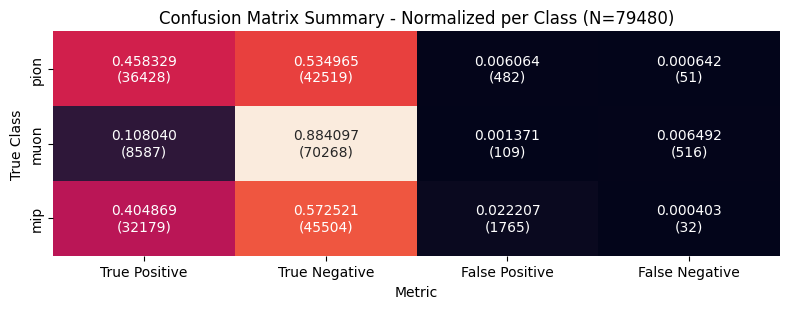

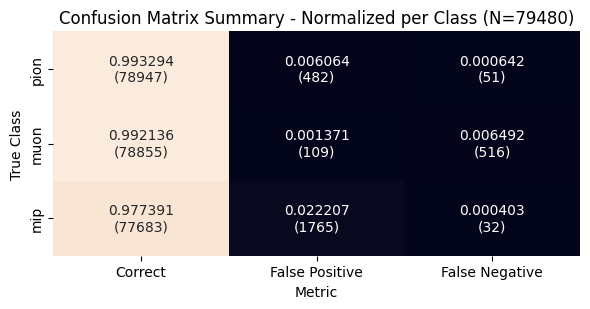

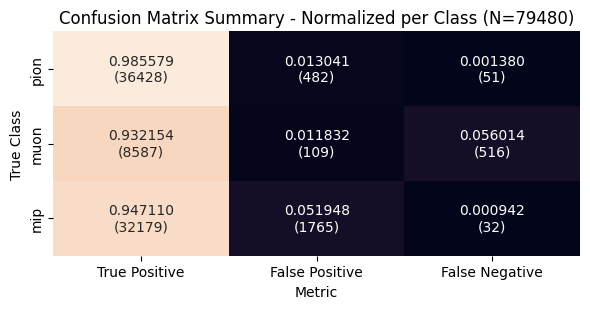

'/workspace/artifacts/validation_plots/group_splitter/group_splitter_20260218_234534_confusion_matrix_summary_true_positives.png'

In [7]:
# 1. Confusion Matrix

print("1. Generating confusion matrices...")

plot_multilabel_confusion_matrix(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    precision=6,
    view_mode="summary",
    summary_mode="default",
    threshold=0.5,
    normalize=True,
    save_path=plots_dir / f"{plot_prefix}_confusion_matrix_summary.png",
    show=True,
)

plot_multilabel_confusion_matrix(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    precision=6,
    view_mode="summary",
    summary_mode="correct_mode",
    threshold=0.5,
    normalize=True,
    save_path=plots_dir / f"{plot_prefix}_confusion_matrix_summary_correct.png",
    show=True,
)

plot_multilabel_confusion_matrix(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    precision=6,
    view_mode="summary",
    summary_mode="true_positive_mode",
    threshold=0.5,
    normalize=True,
    save_path=plots_dir / f"{plot_prefix}_confusion_matrix_summary_true_positives.png",
    show=True,
)

### ROC Curves (Receiver Operating Characteristic)

ROC curves show the trade-off between the true positive rate (sensitivity) and false positive rate (1 - specificity) at different classification thresholds.

**How to interpret:**
- **X-axis (False Positive Rate)**: Proportion of negative samples incorrectly classified as positive. Lower is better.
- **Y-axis (True Positive Rate / Recall)**: Proportion of positive samples correctly identified. Higher is better.
- **Diagonal line (AUC = 0.5)**: Random guessing baseline. Any curve above this indicates the model is learning.
- **AUC (Area Under Curve)**: Higher values mean the model can better distinguish between classes.

**What to look for:**
- Curves that hug the top-left corner indicate better performance
- Higher AUC values mean the model can better distinguish between classes


2. Generating ROC curves...


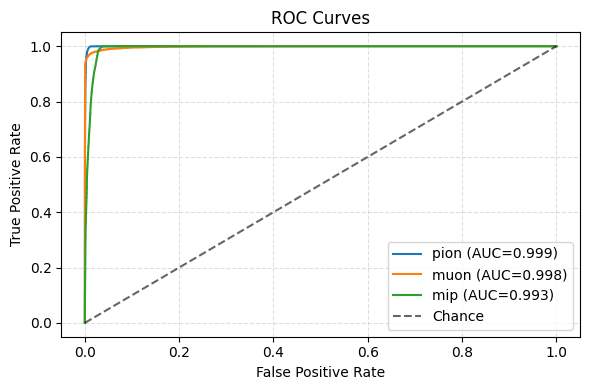

'/workspace/artifacts/validation_plots/group_splitter/group_splitter_20260218_234534_roc_curves.png'

In [8]:
# 2. ROC Curves
print("2. Generating ROC curves...")
plot_roc_curves(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    save_path=plots_dir / f"{plot_prefix}_roc_curves.png",
    show=True,
)

### Precision-Recall Curves

Precision-Recall curves show the relationship between precision (accuracy of positive predictions) and recall (coverage of positive samples) at different thresholds.

**How to interpret:**
- **X-axis (Recall)**: Proportion of actual positives that were correctly identified. Also called sensitivity or true positive rate.
- **Y-axis (Precision)**: Proportion of predicted positives that are actually positive. Measures prediction quality.
- **AP (Average Precision)**: The area under the PR curve. Higher values indicate better performance.

**What to look for:**
- Curves that stay high on the Y-axis (high precision) indicate confident, accurate predictions
- Curves that extend far right (high recall) mean the model finds most positive samples
- **Precision-Recall vs ROC**: PR curves are more informative than ROC when classes are imbalanced


3. Generating precision-recall curves...


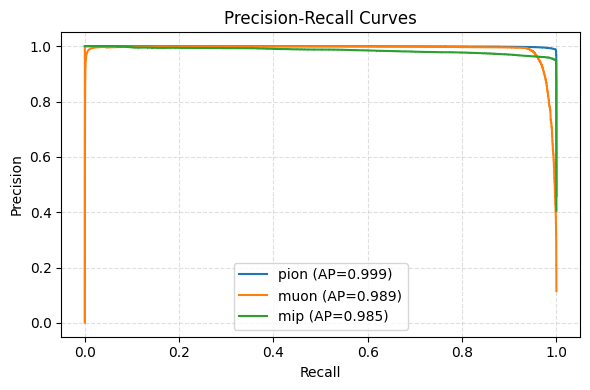

'/workspace/artifacts/validation_plots/group_splitter/group_splitter_20260218_234534_precision_recall.png'

In [9]:
# 3. Precision-Recall Curves
print("3. Generating precision-recall curves...")
plot_precision_recall_curves(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    save_path=plots_dir / f"{plot_prefix}_precision_recall.png",
    show=True,
)

### Probability Distributions

Show how well separated the probability distributions are for each class. These plots display the predicted probabilities (after softmax) for each hit type.

**How to interpret:**
- **Probability values**: After applying softmax, predictions are converted to probabilities (0-1).
- **Histogram shape**: 
  - Sharp peak near 1.0 for correct class = confident, accurate predictions
  - Broad distribution = uncertain predictions
  - Peak near 0.0 for incorrect classes = good discrimination

**What to look for:**
- Strong peaks at high probability for the correct class indicate confident, accurate predictions
- Low probabilities for incorrect classes show good discrimination


4. Generating probability distribution plots...


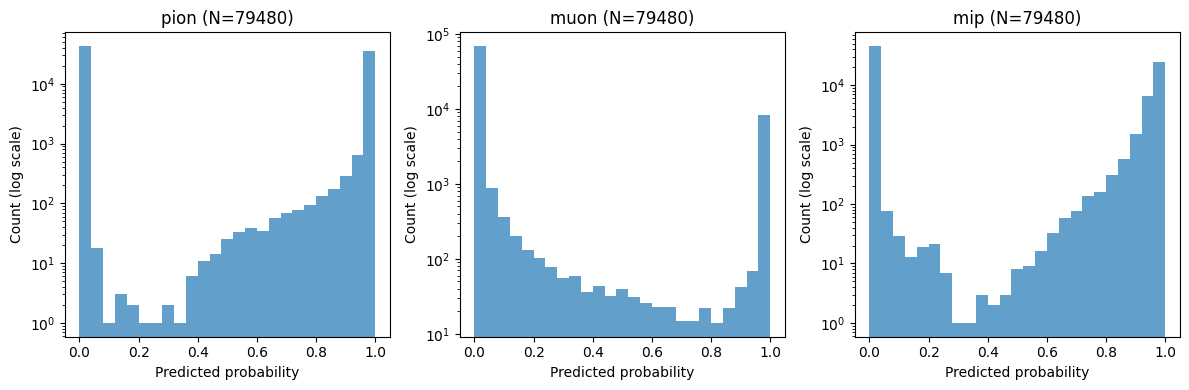

'/workspace/artifacts/validation_plots/group_splitter/group_splitter_20260218_234534_probability_distributions.png'

In [10]:
# 4. Probability Distributions
print("4. Generating probability distribution plots...")
plot_probability_distributions(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    save_path=plots_dir / f"{plot_prefix}_probability_distributions.png",
    show=True,
)

### Confidence Analysis

Analyze the model's confidence in its predictions across different classes and prediction thresholds.

**How to interpret:**
- Shows how confident the model is in its predictions
- Helps identify where the model is uncertain
- Can reveal calibration issues

**What to look for:**
- High confidence for correct predictions indicates good calibration
- Low confidence for incorrect predictions shows the model knows when it's uncertain


5. Generating confidence analysis plots...


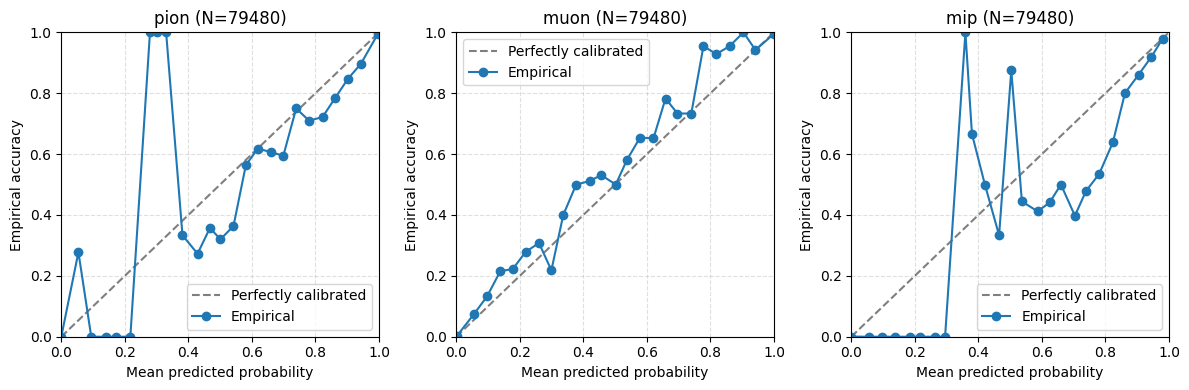

Saved validation plots to: /workspace/artifacts/validation_plots/group_splitter


In [11]:
# 5. Confidence Analysis
print("5. Generating confidence analysis plots...")
plot_confidence_analysis(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    save_path=plots_dir / f"{plot_prefix}_confidence_analysis.png",
    show=True,
)

print(f"Saved validation plots to: {plots_dir}")


### Embedding Analysis

Embedding diagnostics for Group Splitter moved to:

`notebooks/validation/group_splitter_embeddings.ipynb`

That notebook compares input-space and true model embedding-space projections.